<a href="https://colab.research.google.com/github/aasrithanarra/Water-quality-prediction/blob/main/Water_Quality_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import matplotlib.pyplot as plt

# Load the dataset
# Load dataset
df = pd.read_csv('PB_All_2000_2021.csv', sep=';')
df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y')
df = df.sort_values(by=['id', 'date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month


# Basic info
print("Shape of the dataset:", df.shape)
print("\nData Types and Non-Null Counts:")
print(df.info())

# Preview the data
df.head()


Shape of the dataset: (2861, 13)

Data Types and Non-Null Counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2861 entries, 0 to 2860
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   id         2861 non-null   int64         
 1   date       2861 non-null   datetime64[ns]
 2   NH4        2858 non-null   float64       
 3   BSK5       2860 non-null   float64       
 4   Suspended  2845 non-null   float64       
 5   O2         2858 non-null   float64       
 6   NO3        2860 non-null   float64       
 7   NO2        2858 non-null   float64       
 8   SO4        2812 non-null   float64       
 9   PO4        2833 non-null   float64       
 10  CL         2812 non-null   float64       
 11  year       2861 non-null   int32         
 12  month      2861 non-null   int32         
dtypes: datetime64[ns](1), float64(9), int32(2), int64(1)
memory usage: 268.3 KB
None


,id,date,NH4,BSK5,Suspended,O2,NO3,NO2,SO4,PO4,CL,year,month
0,1,2000-02-17,0.330,2.77,12.0,12.30,9.50,0.057,154.0,0.454,289.5,2000,2
1,1,2000-05-11,0.044,3.00,51.6,14.61,17.75,0.034,352.0,0.090,1792.0,2000,5
2,1,2000-09-11,0.032,2.10,24.5,9.87,13.80,0.173,416.0,0.200,2509.0,2000,9
3,1,2000-12-13,0.170,2.23,35.6,12.40,17.13,0.099,275.2,0.377,1264.0,2000,12
4,1,2001-03-02,0.000,3.03,48.8,14.69,10.00,0.065,281.6,0.134,1462.0,2001,3


In [23]:
# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())


Missing values per column:
id            0
date          0
NH4           3
BSK5          1
Suspended    16
O2            3
NO3           1
NO2           3
SO4          49
PO4          28
CL           49
year          0
month         0
dtype: int64


In [24]:
# Convert 'date' to datetime format
df['date'] = pd.to_datetime(df['date'], dayfirst=True)

# Extract Year (optional)
df['year'] = df['date'].dt.year

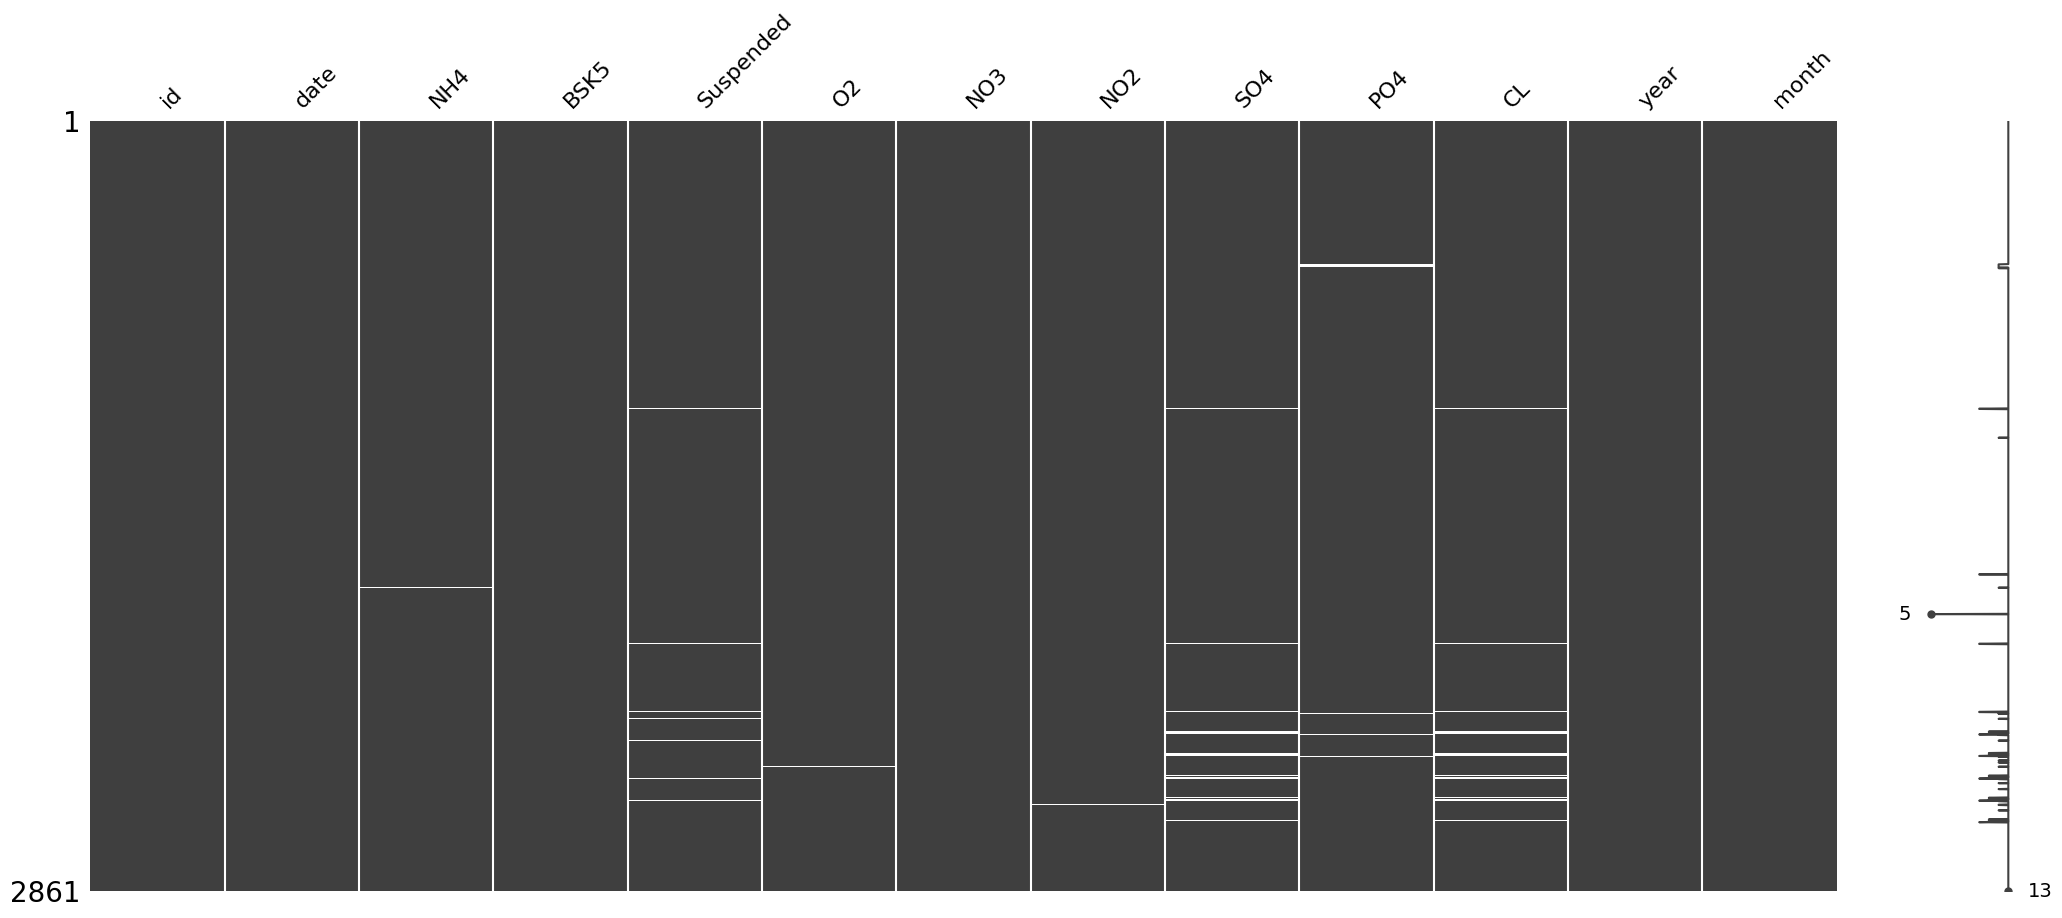

In [25]:
import missingno as msno

# Visual representation of missing data
msno.matrix(df)
plt.show()


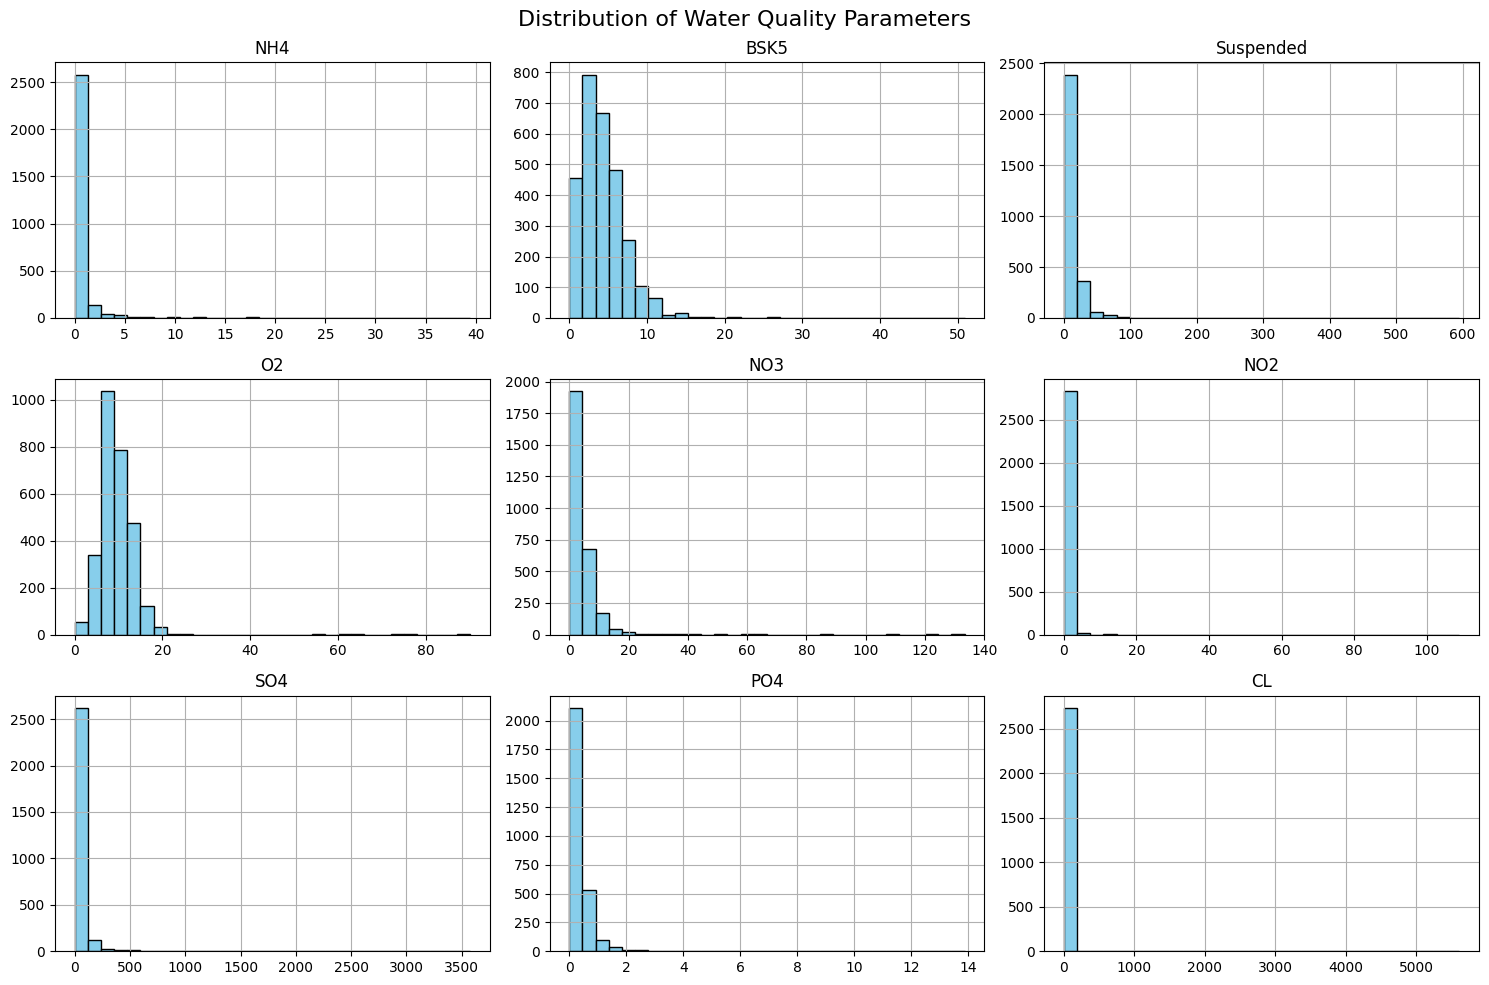

In [26]:
# Plot distributions of all numeric parameters
num_cols = ['NH4', 'BSK5', 'Suspended', 'O2', 'NO3', 'NO2', 'SO4', 'PO4', 'CL']

df[num_cols].hist(bins=30, figsize=(15, 10), color='skyblue', edgecolor='black')
plt.suptitle('Distribution of Water Quality Parameters', fontsize=16)
plt.tight_layout()
plt.show()


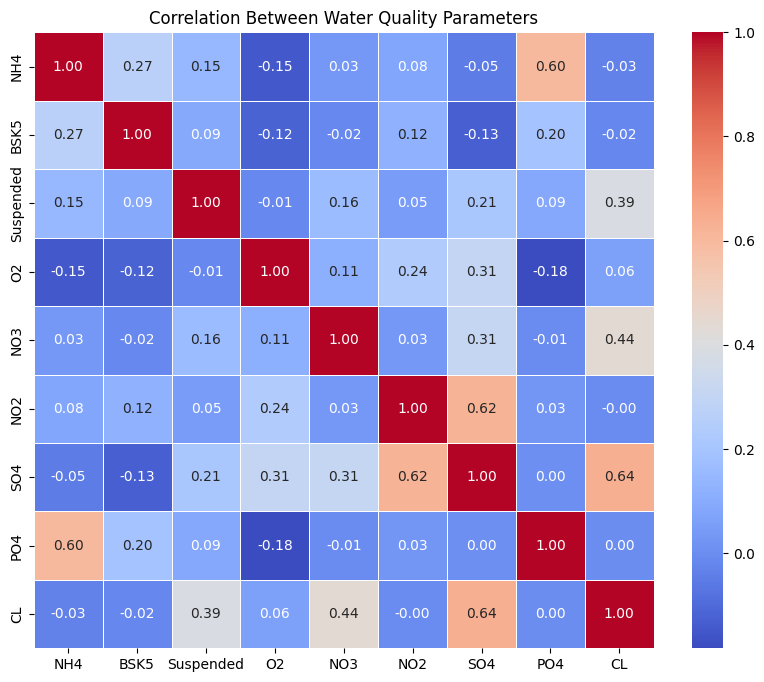

In [27]:
# Compute correlation matrix
corr_matrix = df[num_cols].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Between Water Quality Parameters')
plt.show()


In [28]:
# Select pollutants and clean missing values
pollutants = ['O2', 'NO3', 'NO2', 'SO4', 'PO4', 'CL']
df = df.dropna(subset=pollutants)

In [29]:
# Feature and target selection
X = df[['id', 'year']]
y = df[pollutants]

# One-hot encode station ID
X_encoded = pd.get_dummies(X, columns=['id'], drop_first=True)

In [30]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

In [31]:
# Train MultiOutput RandomForest
model = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42))
model.fit(X_train, y_train)

MultiOutputRegressor(estimator=RandomForestRegressor(random_state=42))

In [32]:
# Evaluate model
y_pred = model.predict(X_test)
print("Model Performance on the Test Data:")
for i, pollutant in enumerate(pollutants):
    print(f'{pollutant}:')
    print('   MSE:', mean_squared_error(y_test.iloc[:, i], y_pred[:, i]))
    print('   R² :', r2_score(y_test.iloc[:, i], y_pred[:, i]))
    print()


Model Performance on the Test Data:
O2:
   MSE: 22.21825046040189
   R² : -0.01674257045728833

NO3:
   MSE: 18.153106746365886
   R² : 0.5162032171220556

NO2:
   MSE: 10.607352172601502
   R² : -78.42066512350873

SO4:
   MSE: 2412.139350033052
   R² : 0.4118345603876148

PO4:
   MSE: 0.38496938017964155
   R² : 0.3221189891402043

CL:
   MSE: 34882.81433245622
   R² : 0.7357918194149974



In [33]:
# Predict for new input
station_id = '22'
year_input = 2024
input_data = pd.DataFrame({'year': [year_input], 'id': [station_id]})
input_encoded = pd.get_dummies(input_data, columns=['id'])

# Align columns
missing_cols = set(X_encoded.columns) - set(input_encoded.columns)
for col in missing_cols:
    input_encoded[col] = 0
input_encoded = input_encoded[X_encoded.columns]

predicted_pollutants = model.predict(input_encoded)[0]
print(f"\nPredicted pollutant levels for station '{station_id}' in {year_input}:")
for p, val in zip(pollutants, predicted_pollutants):
    print(f"  {p}: {val:.2f}")



Predicted pollutant levels for station '22' in 2024:
  O2: 12.60
  NO3: 6.90
  NO2: 0.13
  SO4: 143.08
  PO4: 0.50
  CL: 67.33


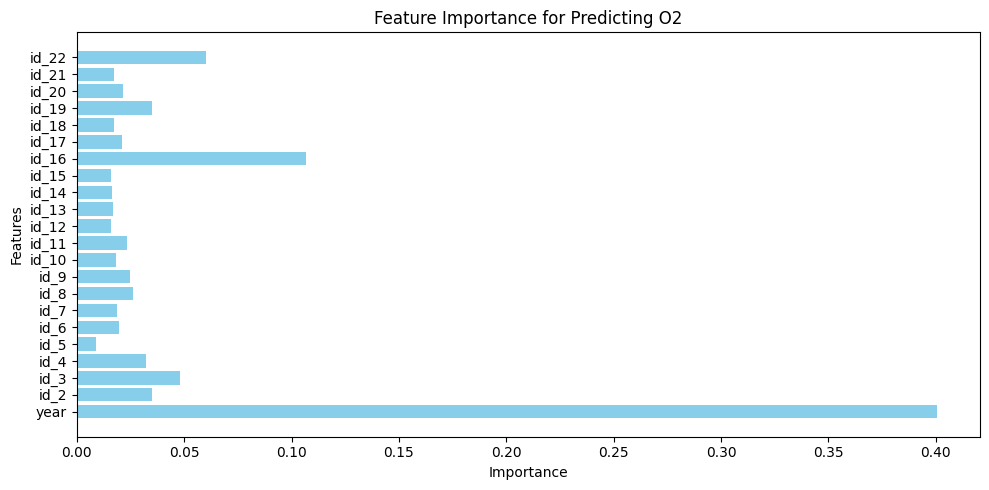

In [34]:
# Show feature importance for first pollutant model (O2)
first_rf_model = model.estimators_[0]  # Model for O2
importances = first_rf_model.feature_importances_

# Plot
plt.figure(figsize=(10, 5))
plt.barh(X_encoded.columns, importances, color='skyblue')
plt.title('Feature Importance for Predicting O2')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

In [35]:
# Save model and columns
joblib.dump(model, 'pollution_model.pkl')
joblib.dump(X_encoded.columns.tolist(), 'model_columns.pkl')
print('Model and columns saved!')

Model and columns saved!
